In [2]:
# Imports
import os
import sys
import json
import time

In [3]:
# Filip Krunic implementation of pageRank
# Parse 
def parseRaw(line):    
    """ This function parses the graph elements from the dictionary."""
    
    # Separate
    array = line.split('\t')
    node, neighbors = array 
    neighbors = eval(neighbors)
    
    # Emit
    for k in neighbors.keys(): 
        yield (node, [k])
        yield (k, [])
        

# Calculate PageRank 
def emitPR(line):    
    # Unpack
    node, prTuple = line
    prList, rank = prTuple
    
    # Emit 
    for neighbor in prList: 
        yield (neighbor, rank / len(prList))
        
        # Danglers 
        yield (node, 0)
        
        
# Compute PR with Teleport 
def dampenedPR(line, danglerLoss, totalDanglers, totalNodes, d=0.85):        
    # Unpack
    node, PR = line 
    
    # Update 
    PR *= d
    PR += (1 - d + d * danglerLoss / totalDanglers ) / totalNodes
    
    # Emit 
    return (node, PR)

In [32]:
# Separated this code into its own method to facilitate re-use
######## INITIALIZE #########
def initPageRank(infile, outfile, n=10):
    # Load 
    graphData = sc.textFile(infile).flatMap(lambda x: parseRaw(x)).reduceByKey(lambda a, b: a + b).cache()
    rank = graphData.map(lambda x: (x[0], 1))

    # Dangling 
    danglers = graphData.filter(lambda x: not bool(x[1]))
    totalDanglers = danglers.count()

    # Diag
    totalNodes = graphData.count()

    # PageRank
    for i in range(n):
        # Neighbor contributions 
        PR = graphData.join(rank).flatMap(lambda x: emitPR(x)).reduceByKey(lambda a, b: a + b)

        # Dangling PR
        danglerPR = PR.join(danglers).map(lambda x: (x[0], x[1][0]))
        danglerLoss = danglerPR.map(lambda x: x[1]).sum()

        # Dampening
        dPR = PR.map(lambda x: dampenedPR(x, danglerLoss, totalDanglers, totalNodes))

        # Normalize 
        totalWeight = dPR.map(lambda x: x[1]).sum()
        nPR = dPR.map(lambda x: (x[0], x[1] / totalWeight))

        # Cycle 
        rank = nPR

    # Results 
    rank.saveAsTextFile(outfile)

In [30]:
# Testing on cluster with toy file 10 iterations
startTime = time.time()
initPageRank('s3://hd-w261/src/PageRank-test.txt', 's3://hd-w261/out/pr10-1')
endTime = time.time()
print '\n'
print '10 iterations took ' + str(endTime - startTime) + " seconds"



10 iterations took 43.2308270931 seconds


In [31]:
# Grab the results from s3, concatenate them together and show the top 10
!aws s3 cp s3://hd-w261/out/pr10-1 ./pr10-1/ --recursive
!cat ./pr10-1/part-* > ./pr10-1/pr10-1.txt
!head ./pr10-1/pr10-1.txt

download: s3://hd-w261/out/pr10-1/_SUCCESS to pr10-1/_SUCCESS
download: s3://hd-w261/out/pr10-1/part-00000 to pr10-1/part-00000
download: s3://hd-w261/out/pr10-1/part-00009 to pr10-1/part-00009
download: s3://hd-w261/out/pr10-1/part-00010 to pr10-1/part-00010
download: s3://hd-w261/out/pr10-1/part-00002 to pr10-1/part-00002
download: s3://hd-w261/out/pr10-1/part-00011 to pr10-1/part-00011
download: s3://hd-w261/out/pr10-1/part-00001 to pr10-1/part-00001
download: s3://hd-w261/out/pr10-1/part-00012 to pr10-1/part-00012
download: s3://hd-w261/out/pr10-1/part-00007 to pr10-1/part-00007
download: s3://hd-w261/out/pr10-1/part-00014 to pr10-1/part-00014
download: s3://hd-w261/out/pr10-1/part-00005 to pr10-1/part-00005
download: s3://hd-w261/out/pr10-1/part-00006 to pr10-1/part-00006
download: s3://hd-w261/out/pr10-1/part-00013 to pr10-1/part-00013
download: s3://hd-w261/out/pr10-1/part-00003 to pr10-1/part-00003
download: s3://hd-w261/out/pr10-1/part-00015 to pr10-1/part-00015
download: s3:/

In [33]:
# Run on wiki data for 10 iterations
startTime = time.time()
initPageRank('s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt', 's3://hd-w261/out/wiki10-1')
endTime = time.time()
print '\n'
print '10 iterations took ' + str(endTime - startTime) + " seconds"



10 iterations took 1477.89627004 seconds


In [53]:
# Slightly modified version of initPageRank that also sorts and grabs the top results
######## INITIALIZE #########
def initPageRankTop(infile, outfile, n=50, top=100):
    # Load 
    graphData = sc.textFile(infile).flatMap(lambda x: parseRaw(x)).reduceByKey(lambda a, b: a + b).cache()
    rank = graphData.map(lambda x: (x[0], 1))

    # Dangling 
    danglers = graphData.filter(lambda x: not bool(x[1]))
    totalDanglers = danglers.count()

    # Diag
    totalNodes = graphData.count()

    # PageRank
    for i in range(n):
        # Neighbor contributions 
        PR = graphData.join(rank).flatMap(lambda x: emitPR(x)).reduceByKey(lambda a, b: a + b)

        # Dangling PR
        danglerPR = PR.join(danglers).map(lambda x: (x[0], x[1][0]))
        danglerLoss = danglerPR.map(lambda x: x[1]).sum()

        # Dampening
        dPR = PR.map(lambda x: dampenedPR(x, danglerLoss, totalDanglers, totalNodes))

        # Normalize 
        totalWeight = dPR.map(lambda x: x[1]).sum()
        nPR = dPR.map(lambda x: (x[0], x[1] / totalWeight))

        # Cycle 
        rank = nPR

        # Results (saved at the 10th and 50th iteration)
        if i in [9, 49]:
            outstr = outfile + str(i+1)
            top100 = rank.top(top, key = lambda x: x[1]) # Sort by the PR value
            sc.parallelize(top100).saveAsTextFile(outstr)

In [54]:
# Validate new method on toy data for 50 iterations
startTime = time.time()
initPageRankTop('s3://hd-w261/src/PageRank-test.txt', 's3://hd-w261/out/pr50-1_', 50, 11)
endTime = time.time()
print '\n'
print '50 iterations took ' + str(endTime - startTime) + " seconds"



50 iterations took 216.78115797 seconds


In [56]:
# Run on wiki data for 50 iterations
startTime = time.time()
initPageRankTop('s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt', 's3://hd-w261/out/wiki50-2_', 50, 100)
endTime = time.time()
print '\n'
print '50 iterations took ' + str(endTime - startTime) + " seconds"



50 iterations took 6325.28141594 seconds


In [57]:
# Grab the results for both the 10 and 50 iterations and concatenate them respectively
!aws s3 cp s3://hd-w261/out/wiki50-2_10 ./wiki50-2_10/ --recursive
!cat ./wiki50-2_10/part-* > ./wiki50-2_10/wiki50-2_10.txt
!aws s3 cp s3://hd-w261/out/wiki50-2_50 ./wiki50-2_50/ --recursive
!cat ./wiki50-2_50/part-* > ./wiki50-2_50/wiki50-2_50.txt

download: s3://hd-w261/out/wiki50-2_10/_SUCCESS to wiki50-2_10/_SUCCESS
download: s3://hd-w261/out/wiki50-2_10/part-00001 to wiki50-2_10/part-00001
download: s3://hd-w261/out/wiki50-2_10/part-00010 to wiki50-2_10/part-00010
download: s3://hd-w261/out/wiki50-2_10/part-00004 to wiki50-2_10/part-00004
download: s3://hd-w261/out/wiki50-2_10/part-00011 to wiki50-2_10/part-00011
download: s3://hd-w261/out/wiki50-2_10/part-00003 to wiki50-2_10/part-00003
download: s3://hd-w261/out/wiki50-2_10/part-00000 to wiki50-2_10/part-00000
download: s3://hd-w261/out/wiki50-2_10/part-00002 to wiki50-2_10/part-00002
download: s3://hd-w261/out/wiki50-2_10/part-00007 to wiki50-2_10/part-00007
download: s3://hd-w261/out/wiki50-2_10/part-00012 to wiki50-2_10/part-00012
download: s3://hd-w261/out/wiki50-2_10/part-00013 to wiki50-2_10/part-00013
download: s3://hd-w261/out/wiki50-2_10/part-00014 to wiki50-2_10/part-00014
download: s3://hd-w261/out/wiki50-2_10/part-00015 to wiki50-2_10/part-00015
download: s3://h

In [59]:
# Examine the results for 10 iterations
!head ./wiki50-2_10/wiki50-2_10.txt

('13455888', 7.104311728575759e-08)
('1184351', 6.964701733280765e-08)
('1384888', 6.886520077547994e-08)
('6113490', 6.87500717957001e-08)
('4695850', 6.845248860169718e-08)
('5051368', 6.817325199432673e-08)
('7576704', 6.792101387148058e-08)
('6076759', 6.780484055654494e-08)
('9276255', 6.771860812426296e-08)
('7835160', 6.766475362052552e-08)


In [60]:
# Examine the results for 50 iterations, note that it's the same pages but the PR value has changed ever so slightly
!head ./wiki50-2_50/wiki50-2_50.txt

('13455888', 7.104311728575786e-08)
('1184351', 6.964701733280794e-08)
('1384888', 6.886520077548022e-08)
('6113490', 6.875007179570038e-08)
('4695850', 6.845248860169746e-08)
('5051368', 6.817325199432701e-08)
('7576704', 6.792101387148086e-08)
('6076759', 6.78048405565452e-08)
('9276255', 6.771860812426323e-08)
('7835160', 6.76647536205258e-08)


In [61]:
# Grab the indices to show the names later
!aws s3 cp s3://ucb-mids-mls-networks/wikipedia/indices.txt .

download: s3://ucb-mids-mls-networks/wikipedia/indices.txt to ./indices.txt


In [65]:
# Examine the format
!tail indices.txt

~Miboujin~ Niku Dorei	15192268	1	0
~VS~ Members	15192269	1	0
~Weta (journal)	15192270	1	0
~Z~ Zetto	15192271	1	0
~binding~	15192272	2	0
~chromatik d zabu.tmp	15192273	1	0
~refrain~ The songs were inspired by Evangelion	15192274	4	1
~scape	15192275	8	0
~~ gender	15192276	1	0
~~	15192277	1	0


In [81]:
# Make a list of tuples for both the 10 iterations and the 50 iterations
# Also make a dictionary out of the indices to consult later
top100_10 = [eval(line) for line in open("./wiki50-2_10/wiki50-2_10.txt")]
top100_50 = [eval(line) for line in open("./wiki50-2_50/wiki50-2_50.txt")]
indices = {key.strip():value.strip() for value, key, v1, v2 in (line.split('\t') for line in open('indices.txt').read().strip().split('\n'))}

In [89]:
# Go through our results and make a list of tuples (#, page10, rank10, page50, rank50)
results = []
for i in range(100):
    p1 = indices.get(top100_10[i][0])
    p2 = indices.get(top100_50[i][0])
    results.append((i+1, p1, top100_10[i][1], p2, top100_50[i][1]))

In [92]:
# Pretty print the results, note that the values seem indentical due to the lower precision
from tabulate import tabulate

print tabulate(results, headers=["#", "page10", "rank10", "page50", "rank50"])

  #  page10                                         rank10  page50                                         rank50
---  ----------------------------------------  -----------  ----------------------------------------  -----------
  1  United States                             7.10431e-08  United States                             7.10431e-08
  2  Animal                                    6.9647e-08   Animal                                    6.9647e-08
  3  Arthropod                                 6.88652e-08  Arthropod                                 6.88652e-08
  4  Insect                                    6.87501e-08  Insect                                    6.87501e-08
  5  France                                    6.84525e-08  France                                    6.84525e-08
  6  Germany                                   6.81733e-08  Germany                                   6.81733e-08
  7  Lepidoptera                               6.7921e-08   Lepidoptera                  

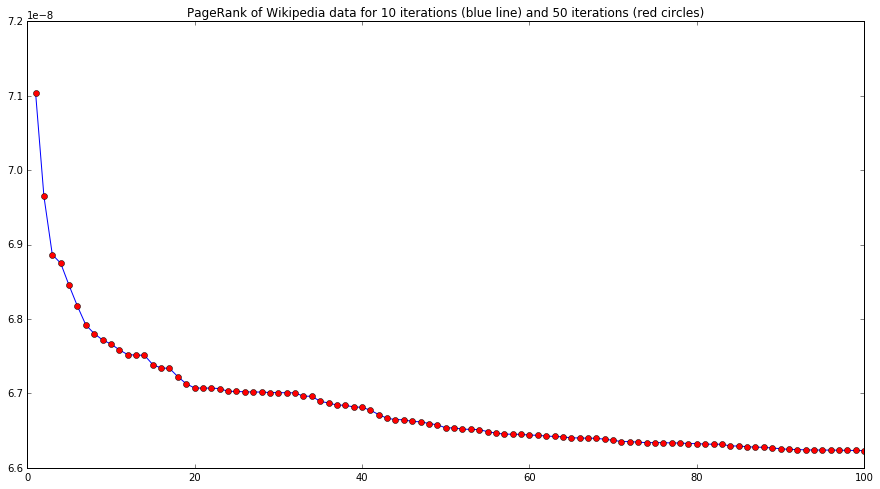

In [99]:
%matplotlib inline
import matplotlib.pyplot as plt

order = range(1,101) # for the x-axis
pr10 = [pr[1] for pr in top100_10] # for the y-axis
pr50 = [pr[1] for pr in top100_50] # for the y-axis

plt.figure(figsize=(15,8))

plt.title("PageRank of Wikipedia data for 10 iterations (blue line) and 50 iterations (red circles)")
plt.plot(order, pr10, 'b', order, pr50, 'ro')
plt.show()
